In [69]:
#Initial Drain Values:

#Vtarget = Vin - (Vset * PLtarget)
#Vnontarget = Vin - (Vreset * PLnontarget)

#((Vtarget - Vnontarget) / PLtarget-nontarget) < Vreset


#!/usr/bin/env python
# coding: utf-8

# In[ ]:


""" 

Run Equilibrium Propagation / Backpropagation on Nanowire Networks for classification. 

Author: Alon Loeffler

Required Files/Folders: learning_functions.py | edamame | asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00.mat

"""

#IMPORTS:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
import os

sys.path.append('/import/silo2/aloe8475/Documents/edamame') #point to edamame locally
sys.path.append('/import/silo2/aloe8475/Documents/CODE/Analysis/Training/Associative Learning/EquilProp') #point to edamame locally

# fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00350_nj_01350_seed_1581_avl_10.00_disp_01.00_lx_50.00_ly_50.00'
fileName='/import/silo2/aloe8475/Documents/Data/Associative Learning/Sparse Networks/asn_nw_00698_nj_02582_seed_002_avl_10.00_disp_01.00_lx_75.00_ly_75.00'

#point to network data path ^ 

saveFig='/import/silo2/aloe8475/Documents/Data/Figures/Equil Prop/' 
dataLoc='/import/silo2/aloe8475/Documents/Data/Associative Learning/EquilProp/'

#import edamame (neuromorphic nanowire python package by Ruomin Zhu)
from edamame import * 
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import loadmat, savemat
import networkx as nx
from tqdm.notebook import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace

import pickle 
import _pickle as cPickle
import gzip

from learning_functions import genGridNW,point_on_line,dist,getWeightedGraph
from learning_functions import calc_cost,setupStimulus,setupSourcesOnly,runTesting,getNWState,calcOutputs

" Create Inputs "
def createSimpleInputs(patternSize=3,numSamples=10,noise=False):
    #SIMPLE ROW INPUTS:
    np.random.seed(42)
    
    if patternSize==2:
    #2x2 pattern:
        orig_inputs=np.array((np.array([1,0,1,0]),np.array([0,1,0,1])))
    elif patternSize==3:
        #3x3 pattern:
        orig_inputs=np.array((np.array([1,0,1,0,1,0,1,0,1]),np.array([0,1,0,1,1,1,0,1,0])))
    orig_inputs=orig_inputs.astype('double')
    samples=[[] for i in range(len(orig_inputs))]
    new_inputs=np.array([orig_inputs]*numSamples)

    #Pattern without Noise
    NoNoiseInputs=[]
    for targetClass in range(len(orig_inputs)):
        NoNoiseInputs.append([int(i) for i in orig_inputs[targetClass]])
#     set_trace()
    #Make Noisy variants of simple patterns:
    for i in range(len(orig_inputs)):
        for j in range(numSamples):
            randVals=np.random.randint(1,patternSize) #choose how many of the 3 sources will have noise
            noiseVals=np.random.randint(patternSize, size=randVals)
            temp=orig_inputs[i][orig_inputs[i]==1].astype('double')
            if noise:
                for val in noiseVals:
                    temp[val]=np.double(np.random.random(1))
            new_inputs[j][i][new_inputs[j][i]==1]=temp
    #         samples[i].append(temp)
    
    #RESHAPE INPUTS INTO numSamplesx2
    row1=[]
    row2=[]
    for i in range(len(new_inputs)):
        row1.append(new_inputs[i][0])
        row2.append(new_inputs[i][1])

    inputs=np.array([row1,row2])
    inputs=inputs.reshape(numSamples*2,orig_inputs.shape[1])
    targets=np.zeros(numSamples*2)
    targets[-numSamples:]=1

    #change 0 volts to 0.05
#     minVoltage=0.005
#     inputs=inputs+minVoltage
    
    return inputs, targets,orig_inputs

" Load Networks "
def buildNetworks(fileName,ManualSources=True,numDrains=2,numSources=9):
    #load data
    nw=loadmat(fileName)
    nwSize = nw['number_of_wires'][0][0]
    this_seed=8639
    Network=nw
    connectivity=connectivity__(wires_dict=Network) 

    #fixing file structure from Matlab:
    connectivity.avg_length=connectivity.avg_length[0][0]
    connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
    connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
    connectivity.dispersion=connectivity.dispersion[0][0]
    # connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
    connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
    connectivity.length_x=connectivity.length_x[0][0]
    connectivity.length_y=connectivity.length_y[0][0]
    connectivity.number_of_wires=connectivity.number_of_wires[0][0]
    connectivity.numOfWires=connectivity.numOfWires[0][0]
    connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
    connectivity.theta=connectivity.theta[0][0]
    connectivity.this_seed=connectivity.this_seed[0][0]
    
    #find x and y values of each end of each wire 
    xa=connectivity.xa[0]
    xb=connectivity.xb[0]
    ya=connectivity.ya[0]
    yb=connectivity.yb[0]

    #Pick Electrode placement/distance apart:
    
    #DRAINS
    numDrains=3
    ex=np.zeros(numDrains)*5#*15
    if nwSize > 500:
        eyVal=76
    else:
        eyVal= 51
    ey=np.linspace(-1,eyVal,numDrains)#(-1,101,numDrains)

    elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates


    #IN A LINE:
    if nwSize > 500:
        exVal=75
        eyVal = 74
    else:
        exVal=50
        eyVal=49
    ex=np.ones(numSources)*exVal#50
    ey=np.linspace(-2,eyVal,numSources)#(-2,99,numSources)
    
    #IN A 3X3 GRID:
    # middleNWx=int(connectivity.length_x/2)+1
    # middleNWy=int(connectivity.length_y/2)-1
    # distBwElecs=10
    # ex=[middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx-distBwElecs,middleNWx,middleNWx,middleNWx,middleNWx+distBwElecs,middleNWx+distBwElecs,middleNWx+distBwElecs]
    # ey=[middleNWy-distBwElecs,middleNWy,middleNWy+distBwElecs]*3

    elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates


    #Manual Source Placement:
    if ManualSources:
        if numSources==9:
            if nwSize > 500:
                elecSource=[678, 260, 491, 173, 628, 424, 301, 236, 483] #700nws
            else:
                elecSource=[23,320,194,74, 145, 317, 129, 34, 141] #350 nws

        elif numSources == 4:
            elecSource=[320,42,161,141]

#     else:    #remove middle drain and sources for simple patterns: if 350 nws
#         if numSources==7:
#             elecSource=elecSource[[0,1,2,4,6,7,8]]
    elecDrain=elecDrain[[0,-1]]
    
    return connectivity,elecSource,elecDrain


#ADD BACKPROP

#This function runs each training epoch and saves the network state at the last timestep of that epoch   
def getNWState_backprop(training_stimulus,state,drains,sources,tmpTiming,tmpTargets,limVal,limVal0,limVal1,run_time=2,dt=0.01,disable_tqdm=False):
    eles = np.append(drains, sources) #all drains
    #     if len(eles) == num_drain_training + num_source_training:
    training_sim,cost = runSim_backprop(connectivity, 
                                   stimulus = training_stimulus,
                                   junctionMode = 'tunneling',
                                   dt = dt, T = run_time, 
                                   contactMode = 'preSet',
                                   electrodes = eles,
                                   findFirst = False,
                                   start_state = state,
                                   disable_tqdm=disable_tqdm,
                                   collapse=True,tmpTiming=tmpTiming,tmpTargets=tmpTargets,
                                   limVal=limVal,limVal0=limVal0,limVal1=limVal1)  
    JS1 = getJunctionState(training_sim, -1) #save state
    #     else: 
    #         print('Bless you Joel :)')
    return training_sim,JS1   

#Combine drain voltage change with runSim:
def runSim_backprop(Connectivity, 
                    junctionMode='binary', collapse=False,
                    criticalFlux=0.1, maxFlux=1.5e-1,
                    contactMode='farthest', electrodes=None,
                    dt=1e-3, T=10, 
                    stimulus = None,
                    biasType = 'DC',
                    onTime=0, offTime=50000000,
                    onAmp=1, offAmp=0.005,
                    f = 1, customSignal = None,
                    start_state = None,
                    lite_mode = False, save_steps = 1,
                    findFirst = True,
                    disable_tqdm = False,
                    freeze_wire = None, freeze_junction = None, 
                    freeze_TimeStamp = None,tmpTiming=[],tmpTargets=[],
                    limVal=0.5,limVal0=0.5,limVal1=0.5):

    """
    For the case of multi electrodes, stimulus should be in parameters.
    See help(stimulus__) for how to generate stimulus__ objects.
    """

    SimulationOptions = simulationOptions__(dt = dt, T = T,
                                            connectivity = Connectivity, 
                                            contactMode = contactMode,
                                            electrodes = electrodes)

    if ((contactMode == 'preSet') and (len(electrodes) > 2)) or stimulus is not None:
        from sys import exit
        if stimulus == None:
            logging.warning(f'Multiple electrodes detected. Please input stimulus in parameters!')
            exit()
        if len(stimulus) < len(SimulationOptions.electrodes):
            diff = len(SimulationOptions.electrodes) - len(stimulus)
            for _ in range(diff):
                stimulus.append(stimulus__('Drain', T = T, dt = dt))

        if len(stimulus) > len(SimulationOptions.electrodes):
            logging.warning(f'More stimulus than electrodes. Current setup has {len(SimulationOptions.electrodes)} electrodes!')
            exit()
            
        if len(stimulus[0].signal) < len(SimulationOptions.TimeVector):
            logging.warning(f'Stimulus length not correct, current time vector has length {len(SimulationOptions.TimeVector)}!')
            exit()
        SimulationOptions.stimulus = stimulus
            
    elif contactMode == 'boundary':
        SimulationOptions.stimulus[:int(len(SimulationOptions.electrodes)/2)] = [stimulus__(biasType = biasType, 
                                                                                        T = T, dt = dt,
                                                                                        onTime = onTime, offTime = offTime,
                                                                                        onAmp = onAmp, offAmp = offAmp,
                                                                                        f = f, customSignal= customSignal)
                                                                                        for i in range(int(len(SimulationOptions.electrodes)/2))]
    else:
        SimulationOptions.stimulus[0] = stimulus__(biasType = biasType, 
                                                T = T, dt = dt,
                                                onTime = onTime, offTime = offTime,
                                                onAmp = onAmp, offAmp = offAmp,
                                                    f = f, customSignal= customSignal)
    if start_state == None: 
        JunctionState = junctionState__(Connectivity.numOfJunctions, 
                                    mode = junctionMode, collapse = collapse, 
                                    criticalFlux=criticalFlux, maxFlux = maxFlux)
    else:
        from copy import deepcopy
        JunctionState = deepcopy(start_state)
    
    kwdict = dict()
    if (freeze_wire != None) or (freeze_junction != None):
        kwdict = dict(freeze_wire = freeze_wire,
                    freeze_junction = freeze_junction, 
                    freeze_TimeStamp = freeze_TimeStamp)
        
    this_realization,cost = simulateNetwork_backprop(SimulationOptions, Connectivity, JunctionState,tmpTiming,tmpTargets,limVal,limVal0,limVal1,lite_mode, disable_tqdm, save_steps, **kwdict)
    
#     finalIter=np.max(np.nonzero(this_realization.electrodeCurrent))
#     if finalIter < 199:
#         this_realization.electrodeCurrent=this_realization.electrodeCurrent[:finalIter+1,:]
#         this_realization.junctionVoltage=this_realization.junctionVoltage[:finalIter+1,:]
#         this_realization.junctionConductance=this_realization.junctionConductance[:finalIter+1,:]
#         this_realization.wireVoltage=this_realization.wireVoltage[:finalIter+1,:]
#         this_realization.filamentState=this_realization.filamentState[:finalIter+1,:]
#         this_realization.junctionSwitch=this_realization.junctionSwitch[:finalIter+1,:]
        #final Iter = time , use that to find / save network state
        
        
#         this_realization.TimeVector=this_realization.TimeVector[:finalIter+1,:]

    #     remove zeros from simulations that ended early:
#     this_realization.junctionCurrent
    
    if findFirst:
        from edamame.analysis.GraphTheory import findCurrent
        try:
            activation = findCurrent(this_realization, 1)
            logging.info(f'First current path {activation[0][0]} formed at time = {activation[1][0]} s.')
        except:
            logging.info('Unfortunately, no current path is formed in simulation time.')

    return this_realization,cost

def simulateNetwork_backprop(simulationOptions, connectivity, junctionState,tmpTiming,tmpTargets, limVoltage,limVal0,limVal1,lite_mode = False, disable_tqdm = False, save_steps = 1, **kwargs):
    niterations = simulationOptions.NumOfIterations
    electrodes = simulationOptions.electrodes
    numOfElectrodes = len(electrodes)
    E = connectivity.numOfJunctions
    V = connectivity.numOfWires
    edgeList = connectivity.edge_list
#     onAmp     = simulationOptions.stimulus[3].onAmp
    
#     maxV      = onAmp *limVoltage
    n         = num_drain_training #num of drains
    cost      = []
    beta      = 0.05
    grad      = np.zeros((n)) #set gradients to zero for each epoch  

    Network = network__()
    sampling = np.arange(0, niterations, save_steps)
    if lite_mode:
        Network.connectivity = connectivity__(adjMat = connectivity.adj_matrix)
        Network.filamentState = np.zeros((int(niterations/save_steps), E))
        Network.wireVoltage = np.zeros((int(niterations/save_steps), V))
        Network.electrodeCurrent = np.zeros((int(niterations/save_steps), numOfElectrodes))
        Network.TimeVector = np.zeros(int(niterations/save_steps))
    else:        
        Network.connectivity = connectivity
        Network.TimeVector = simulationOptions.TimeVector
        Network.filamentState = np.zeros((niterations, E))
        Network.junctionVoltage = np.zeros((niterations, E))
        # Network.junctionResistance = np.zeros((niterations, E))
        Network.junctionConductance = np.zeros((niterations, E))
        Network.junctionSwitch = np.zeros((niterations, E), dtype = bool)
        Network.wireVoltage = np.zeros((niterations, V))
        Network.electrodeCurrent = np.zeros((niterations, numOfElectrodes))

    Network.sources = []
    Network.drains = []
    for i in range(numOfElectrodes):
        if np.mean(simulationOptions.stimulus[i].signal) != 0:
            Network.sources.append(electrodes[i])
        else:
            Network.drains.append(electrodes[i])

    if len(Network.drains) == 0:
        Network.drains.append(electrodes[1])

    if 'freeze_wire' in kwargs:
        freeze_wire = kwargs['freeze_wire']
        freeze_TimeStamp = kwargs['freeze_TimeStamp']
    else:
        freeze_TimeStamp = niterations + 1
    
    #Simulation Run:
#     new_time=0
    stopTrain=False
    for this_time in tqdm(range(niterations), desc='Running Simulation ', disable = disable_tqdm): #each time step
        if not stopTrain:
            this_stimulus = np.array([i.signal[this_time] for i in simulationOptions.stimulus])

        if tmpTiming[this_time]=='Train':
#             print('--------')
#             print('Training')
#             print('--------\n')
            trainTime=True
        elif tmpTiming[this_time]=='Test':
#             print('--------')
#             print('Testing')
#             print('--------\n') 
            trainTime=False

        if trainTime and this_time > 0 and not stopTrain: #if we are training, change drain voltages, otherwise just use this_stimulus
            this_stimulus[:num_drain_training]=new_stimulus             
#             print('in training '+str(this_time))
#         elif this_time > trainTime:

        sol = simCore(connectivity, junctionState, this_stimulus, electrodes, simulationOptions.dt)

        if this_time >= freeze_TimeStamp:
            others = np.setdiff1d(range(V), freeze_wire)
            wireVoltage[others] = sol[others]
        else:
            wireVoltage = sol[0:V]

        if lite_mode:
            if this_time%save_steps == 0:
                Network.wireVoltage[this_time//save_steps,:] = wireVoltage
                Network.electrodeCurrent[this_time//save_steps,:] = sol[V:]
                Network.filamentState[this_time//save_steps,:] = junctionState.filamentState
                Network.TimeVector[this_time//save_steps] = simulationOptions.TimeVector[this_time]
        else:
            Network.wireVoltage[this_time,:] = wireVoltage
            Network.electrodeCurrent[this_time,:] = sol[V:]
            Network.filamentState[this_time,:] = junctionState.filamentState
            Network.junctionVoltage[this_time,:] = junctionState.voltage
            Network.junctionConductance[this_time,:] = junctionState.conductance
            Network.junctionSwitch[this_time,:] = junctionState.OnOrOff

        ## BackProp Implementation
        y = Network.electrodeCurrent[this_time,:num_drain_training]
        drainCurrents=y
        if tmpTargets[this_time] != -1: #skip rest values
            tarIdx=tmpTargets[this_time]
            if tarIdx==1:
                nonIdx=0
            else:
                nonIdx=1
            y = y/(maxCurrent[tarIdx]) # normalize  | | | how do we change max current to be not arbitrary? 
        # current method - run simulation before with just that drain and use current as maxCurrent

            # change to threshold 
            d = allTargets[tarIdx]

            dsig = this_stimulus[:num_drain_training]
            
            #fixed max voltage
            # compare y with threshold - if y is >= thresh, stop the training
#             set_trace()

            #vectorised implementation

            cost.append(calc_cost(y,d))

            if trainTime and not stopTrain: #if we are training, update beta
                #Gradient without considering other electrodes:
                if tarIdx==0:
                    if drainCurrents[0]>=limVal0: #if greater or less than the target current, stop the simulation
                        this_stimulus=np.zeros(len(this_stimulus))
                        stopTrain=True
                    else:
                        stopTrain=False
                        #instead of ending session, make everything 0V (inputs + drains)
                        #make sure this doesn't last longer than filament decay length
                elif tarIdx==1:
                    if drainCurrents[1]>=limVal1: #if greater or less than the target current, stop simulation
                        this_stimulus=np.zeros(len(this_stimulus))
                        stopTrain=True
                    else:
                        stopTrain=False
                        
                grad=beta*(y-d) #y = current, d = target #e.g. [y1 vs (d1 = 1), y2 vs (d2 = 0), y3vs (d3 = 0)]

                #dsig = old voltage drains, dsig2 = new voltage drains, onAmp = input voltage

                dsig2=np.array(dsig.T+grad)
#                     dsig2[0]=np.clip(dsig2[0],0,limVal0)
#                     dsig2[1]=np.clip(dsig2[1],0,limVal1)

                dsig2=np.clip(dsig2,-onAmp,onAmp) #set max and min voltages to less than inputs

                new_stimulus=dsig2

            else:
                new_stimulus=this_stimulus[:num_drain_training]

    print('Target:' + str(tarIdx))
#     print('Voltage: '+ str(new_stimulus))
    
    Network.numOfWires = V
    Network.numOfJunctions = E
    Network.electrodes = simulationOptions.electrodes
    if len(electrodes) <= 2:
        Network.conductance = Network.electrodeCurrent[:,1]/simulationOptions.stimulus[0].signal[sampling]
    if not lite_mode:
        Network.stimulus = [simulationOptions.stimulus[i] for i in range(numOfElectrodes)]
        Network.junctionResistance = 1/Network.junctionConductance
        
    return Network,cost



def runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks=[],maxCurrent=[1e-5,1e-5],limVal=0.5,accThresh=0.5,increaseVal=0.5,decreaseVal=0.25,seed=42,accThreshold=False):
    """
    n-back task:
    input sample 1 with backprop, then sample 2 with backprop, then sample 1 again with reset drain voltages 
    n back here = 1, showing memory
    
    train sample x, test sample x + nback (e.g. nback = 2, sample = [s1 train,s2,s3,s1 test] )

    increase n-back: 
    sample 1 with backprop, sample 2, sample 3... test sample 1 - n=2
    
    Things to test:
    - if we increase input frequency (dt), do we see greater long term memory? (higher n-backs)
    - if we decrease frequency, do we see greater short term memory? (lower n-backs)

    """  
    
    t           = [[None]*120 for i in range(len(nbacks))]
    simVoltages = []
    saveStim    = []
    count=0
    for nback in nbacks: #how many samples to "remember" in the past before testing
        np.random.seed(seed)
        
        numTestingSamples= 40 #how many samples across all nback values
        
        #completely random order
        orderTraining = np.random.choice(len(trainingInputs),size=len(trainingInputs),replace=False)
        
        orderTrainingLabels=traininglabels[orderTraining]
        orderTrainingLabelsNBACK=orderTrainingLabels[::nback] #these are the testing labels - every i+nback training sample is what we're testing
        orderTesting=[]
        for label in orderTrainingLabelsNBACK: #for each training label in the random order:
            orderTesting.append(np.random.choice(np.where(testinglabels==label)[0]))
        orderTestingLabels=testinglabels[orderTesting]    
        orderTestingNBACK=np.array(orderTesting)+len(orderTraining) #number of test per nback
         #choose how many samples between testing samples:
        i = nback
        temp=[]
        j=0
        order=[None]*(len(orderTraining))
        order[:len(orderTraining)]=orderTraining
        while j<numTestingSamples: #for each testing sample 
            if i < len(order): #only if we are within the total number of training samples
                order.insert(i, orderTesting[j]+len(orderTraining)) #insert testing sample at ith position
            temp.append(i) #keep track number of inserts we made, make sure it == numTestingSamples
            i += nback+1
            j +=1
        
        
        #remove excess training (i.e. with no testing sample)
        sampleTimes=numDT*(nback+1)
        newTrainingOrder=orderTraining[:sampleTimes-numTestingSamples]
        orderTrainingLabels=orderTrainingLabels[:sampleTimes-numTestingSamples]
        order=order[:sampleTimes]
        
        
#         print(order)
#         print(len(order))
        #RUN SIM
        N                   = orig_inputs.shape[1]
        numClasses          = 2
        signalType          ='DC'
        num_drain_training  = 2
        num_source_training = N
        tmpSources          = [[] for i in range(len(order))]
        tmpTargets          = [None]*len(order)
        sim                 = [None]*len(order)
        thresholdValues     = [None]*len(order)
        cost                = [None]*len(order)
        simVoltages         = [None]*len(order)
        accuracy    = []
        numTrainingSamples  = len(trainingInputs)
        numTestingSamples   = len(testingInputs)
        
        timing=[]
        allLabels=[]
        limVals0 = limVal
        limVals1 = limVal
        
        i=0
        numTests = 0
        nwState = None
        for val in order: #this method loops through samples in the randomised training order
            
            #FOR EACH SAMPLE:
            
            #are we training or testing?
            if val in orderTestingNBACK:
                test=True
                train=False
            elif val in orderTraining:
                test=False
                train=True
                
            #define samples
            if train: #if we're training
                this_sample = trainingInputs[val].copy() #xs
                this_label  = traininglabels[val] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmp #tune voltage based on onAmp
                timing.append('Train')

            elif test: #if we're testing
                this_sample = testingInputs[val-len(orderTraining)].copy() #xs
                this_label  = testinglabels[val-len(orderTraining)] #ys
                this_sample[this_sample>0.005]=this_sample[this_sample>0.005]*onAmpTest
                timing.append('Test')

#             targetClassVals=[0,1] 

            targetTmp = signal_expand(this_label,numDT) #number of timesteps per target
            timing[i] = signal_expand(timing[i],numDT)
        #     #array of nans:
            tmpArray=np.empty(restDur)
            tmpArray[:]=-1
            targetTmp = np.append(targetTmp,tmpArray) #add rest #need to remove targets from rest
            tmpTargets[i]=targetTmp 
            for j in range(len(this_sample)): #for each source electrode
                tmp = signal_expand(this_sample[j],numDT)
                tmp = np.append(tmp,np.zeros(restDur)) #add rest
                tmpSources[i].append(tmp)
            allLabels.append(this_label)
            
            
            drainSPL1=nx.shortest_path_length(nx.from_numpy_array(connectivity.adj_matrix),sources[4],drain_pool[1])
            drainSPL0=nx.shortest_path_length(nx.from_numpy_array(connectivity.adj_matrix),sources[4],drain_pool[0])

            
            if targetTmp[0]==1: #set drain voltages to inital state:
                vTar=onAmp-(1e-2*drainSPL0)
                vNonTar=onAmp-(1e-3*drainSPL1)
                dv=[signal_expand(vNonTar,numDT),signal_expand(vTar,numDT)]
            else:
                vTar=onAmp-(1e-2*drainSPL1)
                vNonTar=onAmp-(1e-3*drainSPL0)
                dv=[signal_expand(vTar,numDT),signal_expand(vNonTar,numDT)]
#             set_trace()
            stimulus=[]
            if train:
                for m in range(num_drain_training): #create stimulus for each drain electrode
                    stimulus.append(stimulus__(biasType='Custom',T=dt*len(tmpSources[i][m]),dt=dt,customSignal=dv[m]))
            elif test:
                for m in range(num_drain_training): #create stimulus for each drain electrode
                    stimulus.append(stimulus__(biasType='Drain',T=dt*len(tmpSources[i][m]),dt=dt))

            for m in range(len(tmpSources[i])): #create stimulus for each source electrode
                stimulus.append(stimulus__(biasType='Custom',T=dt*len(tmpSources[i][m]),dt=dt,customSignal=tmpSources[i][m]))
            
            signalLen=len(stimulus[0].signal) 
            
            sim[i],nwState = getNWState_backprop(stimulus,nwState,drain_pool,sources,timing[i],tmpTargets[i].astype('int'),limVal,limVals0,limVals1,run_time=int(signalLen*dt),dt=dt,disable_tqdm=False)

            simVoltages[i]=(sim[i].wireVoltage)
            
            t[count][i]=(calcOutputs(sim[i],sources,drain_pool))
        
            if test: #if we are testing
                #calucalte accuracy
                accThreshold=False
                if accThreshold:
                    #add threshold of difference to ensure accuracy:
                    argmaxvals=np.argmax([t[count][i][0],t[count][i][1]],axis=0)

                    for s in range(len(argmaxvals)):
                        if abs(t[count][i][0][s]-t[count][i][1][s])>1e-6 and argmaxvals[s]==1:
                            argmaxvals[s]=1
                        elif abs(t[count][i][0][s]-t[count][i][1][s])<1e-6 and argmaxvals[s] == 1:
                            argmaxvals[s]=0
#                     accuracy.append(np.sum(argmaxvals==tmpTargets[testTimes])/len(tmpTargets[testTimes]))
                    accuracy.append(np.sum(argmaxvals==tmpTargets[i-nback])/len(tmpTargets[i-nback]))
                else:
                    accuracy.append(np.sum(np.argmax([t[count][i][0],t[count][i][1]],axis=0)==tmpTargets[i-nback])/len(tmpTargets[i-nback]))
                
                if i >0:
                    if accuracy[numTests]<=accThresh: #if the accuracy is less than or equal to chance
                        if this_label==0: #drain 1
                            limVals0=limVals0+increaseVal #update 'max current limit based on reinforcement'
                            limVals1=limVals1-decreaseVal
                        elif this_label==1: #drain 2
                            limVals0=limVals0-decreaseVal
                            limVals1=limVals1+increaseVal                           
                
                print('Target: ' + str(tmpTargets[i][0]))
                print('Accuracy: '+ str(accuracy[numTests]))
                numTests+=1
                
            fval1=np.max(np.nonzero(t[count][i][0]))
            fval2=np.max(np.nonzero(t[count][i][1]))
            print('Currents: ' + str([t[count][i][0][fval1],t[count][i][1][fval2]]))
            print("LimVal1:" + str(limVals1)) #just a checking/debugging print
            print("LimVal0:" + str(limVals0)) #just a checking/debugging print

            thresholdValues[i]=[limVals0,limVals1]
            i+=1 
        
        count+=1
    return t,thresholdValues,sim,stimulus,accuracy,tmpTargets,newTrainingOrder,orderTesting,order,orderTestingLabels,testTimes,trainTimes,numTestingSamples,allLabels,orderTrainingLabels

def trainTestSplit(inputs,targets,targetClassVals=[0,1],numTestingPerClass=3,orig_inputs=[]):
    trainingInputs  = np.array([inputs[targets==targetClassVals[0]][:-numTestingPerClass],inputs[targets==targetClassVals[1]][:-numTestingPerClass]]).reshape(-1,orig_inputs.shape[1])
    testingInputs   = np.array([inputs[targets==targetClassVals[0]][-numTestingPerClass:],inputs[targets==targetClassVals[1]][-numTestingPerClass:]]).reshape(-1,orig_inputs.shape[1])
    #Define Training and Testing labels
    traininglabels=np.zeros(len(trainingInputs))
    traininglabels[:int(len(trainingInputs)/2)]=0
    traininglabels[int(len(trainingInputs)/2):int(len(trainingInputs)/2)*2]=1
    # traininglabels[int(len(trainingInputs)/3)*2:]=2
    traininglabels=traininglabels.astype(int)

    testinglabels=np.zeros(len(testingInputs))
    testinglabels[:int(len(testingInputs)/2)]=0
    testinglabels[int(len(testingInputs)/2):int(len(testingInputs)/2)*2]=1
    # testinglabels[int(len(testingInputs)/3)*2:]=2
    testinglabels=testinglabels.astype(int)
    
    return trainingInputs,testingInputs,traininglabels,testinglabels


#TASK SETUP

# print('Loading Networks + Training Data')
ManualSources=True
numSamples=50

patternSize= 3 #2 or 3
numSources=9 # 4 or 7

num_drain_training=2
allTargets=[[1,0],[0,1]]
targetClassVals=[0,1]
numTestingPerClass=10

noisey=False

#create networks
connectivity,sources,drain_pool=buildNetworks(fileName,ManualSources,num_drain_training,numSources)

#create samples
inputs,targets,orig_inputs=createSimpleInputs(patternSize,numSamples,noisey) #pattern size (e.g 3x3 = 3), number of samples, noise

#split samples to train test
trainingInputs,testingInputs,traininglabels,testinglabels = trainTestSplit(inputs,targets,targetClassVals,numTestingPerClass,orig_inputs=orig_inputs)

#Run n-back Task
dt=0.01

accThreshold=False #do we want to force a minimum (arbitrary) difference between target and non-target drain for accuracy to be counted?

Tlen = 200
timesteps   = Tlen/dt
numDT       = int(timesteps/len(inputs)) #number of timesteps per sample
restDur=0

#Amplitude:
onAmp = 2 #Voltage for Training
onAmpTest = 0.5 #Voltage for Testing

#Other Variables
maxCurrent = [1e-5,1e-5] #target
threshCurrent = [5e-6,5e-6]
nbacks         = [2]#range(1,5)
numRuns        = 1
sim            = [None]*numRuns
stimuli        = [None]*numRuns
accuracy       = [None]*numRuns

trainingOrder = [None]*numRuns
testingOrder = [None]*numRuns
testingLabels  = [None]*numRuns
trainingLabels  = [None]*numRuns
order          = [None]*numRuns
testTimes      = [None]*numRuns
trainTimes      = [None]*numRuns
targets        = [None]*numRuns
numTestingSamples = [None]*numRuns
allLabels      = [None]*numRuns
seeds          =  np.random.choice(10000,size=numRuns,replace=False)

limValues = [threshCurrent[0]]#[1e-6]#list(np.arange(0.05,1.05,0.05))  #if we want to loop through onAmp limit voltage percentage for drains
increaseVal=threshCurrent[0]/5
decreaseVal=threshCurrent[0]/10
accThresh=0.7

loadOnly=False


if loadOnly == False:
    print('Running')
    meanAcc=[]
    stdAcc=[]
    outputs=[]
    for val in tqdm(limValues):
        print(val)
        for i in tqdm(range(numRuns)):
            outputs.append(runNBACK(onAmp,onAmpTest,dt,Tlen,timesteps,numDT,restDur,nbacks,maxCurrent,val,accThresh,increaseVal,decreaseVal,seed=seeds[i],accThreshold=accThreshold))
    print('Saving')
    if numRuns==1:
        outputs=outputs[0]
        t=outputs[0][0][:-1]
        thresholds=outputs[1]
        sim=outputs[2]
        accuracy=outputs[4]
        alltargets=outputs[5]
        trainingOrder=outputs[6]
        trainingLabels=outputs[-1]
        testingLabels=outputs[9]
        allLabels=outputs[-2]
        numTestingSamples=outputs[-3]
    else:
        t = [None]*numRuns;thresholds=[None]*numRuns;sim=[None]*numRuns;accuracy=[None]*numRuns;alltargets=[None]*numRuns
        trainingOrder=[None]*numRuns;trainingLabels=[None]*numRuns;testingLabels=[None]*numRuns;allLabels=[None]*numRuns
        for run in range(numRuns):
            t[run]=outputs[run][0][0][:-1]
            thresholds[run]=outputs[run][1]
            sim[run]=outputs[run][2]
            accuracy[run]=outputs[run][4]
            alltargets[run]=outputs[run][5]
            trainingOrder[run]=outputs[run][6]
            trainingLabels[run]=outputs[run][-1]
            testingLabels[run]=outputs[run][9]
            allLabels[run]=outputs[run][-2]
            numTestingSamples=outputs[run][-3]
            
    params={'Voltage':onAmp,'Test Voltage':onAmpTest,'Threshold Value':limValues,'Accuracy Threshold':accThresh,'ThreshIncrease':increaseVal,'ThreshDecrease':decreaseVal,'Random Seed':seeds,'Timesteps':Tlen,'Target Currents':maxCurrent,'dt':dt,'Num Samples':[119],'Num Trials':numRuns,'Noise':noisey}
#     if patternSize==2:
#         savemat(dataLoc+'nback'+str(nbacks[0])+'_data_350nw_1350nj_reinforcement_2x2_wLimThreshold_wAccThreshold.mat', {'Data':{'current':t,'threshold':thresholds, 'sim':sim,'accuracy':accuracy,'targets':alltargets,'training order':trainingOrder,'training labels':trainingLabels,'testing labels':testingLabels,'all labels':allLabels,'num test samples':numTestingSamples,'Parameters':params}})
#     else:
#         savemat(dataLoc+'nback'+str(nbacks[0])+'_data_350nw_1350nj_reinforcement_3x3_wLimThreshold_wAccThreshold.mat', {'Data':{'current':t,'threshold':thresholds, 'sim':sim,'accuracy':accuracy,'targets':alltargets,'training order':trainingOrder,'training labels':trainingLabels,'testing labels':testingLabels,'all labels':allLabels,'num test samples':numTestingSamples,'Parameters':params}})        
#     savemat(dataLoc+'nback'+str(nbacks[0])+'_data_700nw_2545nj_reinforcement_3x3_wLimThreshold_wAccThreshold.mat', {'Data':{'current':t,'threshold':thresholds, 'sim':sim,'accuracy':accuracy,'targets':alltargets,'training order':trainingOrder,'training labels':trainingLabels,'testing labels':testingLabels,'all labels':allLabels,'num test samples':numTestingSamples,'Parameters':params}})        

else:
    print('Loading')
    out=loadmat(dataLoc+'nback'+str(nbacks[0])+'_data_350nw_1350nj_reinforcement_2x2_wLimThreshold_wAccThreshold.mat')
    out=out['Data'][0][0]
    t=out[0]
    thresholds=out[1]
    sim=out[2][0]
    accuracy=out[3][0]
    alltargets=out[4]
    trainingOrder=out[5][0]
    trainingLabels=out[6][0]
    testingLabels=out[7][0]
    allLabels=out[8][0]
    numTestingSamples=out[9][0][0]


Running


  0%|          | 0/1 [00:00<?, ?it/s]

5e-06


  0%|          | 0/1 [00:00<?, ?it/s]

Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-1.028156355854221e-06, 1.770976697802195e-05]
LimVal1:5e-06
LimVal0:5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-4.324288140358447e-06, 6.284119456377635e-06]
LimVal1:5e-06
LimVal0:5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 1.0
Currents: [2.9454241466095193e-08, 7.3294944169999274e-06]
LimVal1:5e-06
LimVal0:5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-5.9039484255231295e-08, 5.188715724524212e-06]
LimVal1:5e-06
LimVal0:5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [7.220331140748083e-06, -3.1067338098219366e-06]
LimVal1:5e-06
LimVal0:5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.02
Currents: [6.855670193373632e-06, 6.052765869050559e-08]
LimVal1:6e-06
LimVal0:4.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [7.12949922018217e-06, -3.8079340452313085e-07]
LimVal1:6e-06
LimVal0:4.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [5.209644913512322e-06, -7.641688966257315e-07]
LimVal1:6e-06
LimVal0:4.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 1.0
Currents: [2.8091960362993653e-06, 1.4508289738966372e-08]
LimVal1:6e-06
LimVal0:4.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [4.154255985553333e-07, 1.2123956559088726e-05]
LimVal1:6e-06
LimVal0:4.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.1289008592426612e-05, -2.4965029509381215e-07]
LimVal1:6e-06
LimVal0:4.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.0
Currents: [4.859126955116683e-06, 4.3712756576334e-08]
LimVal1:7.000000000000001e-06
LimVal0:4e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-1.4910512943622761e-06, 1.7127002005971304e-05]
LimVal1:7.000000000000001e-06
LimVal0:4e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-3.1210683578752556e-07, 7.397955695769654e-06]
LimVal1:7.000000000000001e-06
LimVal0:4e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.825
Currents: [3.6156289048923712e-06, 7.605796659602121e-06]
LimVal1:7.000000000000001e-06
LimVal0:4e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [6.537509795284313e-06, 9.597034826059926e-06]
LimVal1:7.000000000000001e-06
LimVal0:4e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [7.291201262412816e-06, -6.993984944414043e-07]
LimVal1:7.000000000000001e-06
LimVal0:4e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.745
Currents: [6.325264933813255e-07, 8.845872469899338e-08]
LimVal1:7.000000000000001e-06
LimVal0:4e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [4.466947327756359e-06, -1.0906619829041423e-07]
LimVal1:7.000000000000001e-06
LimVal0:4e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-1.3610617812031767e-07, 1.9105761366407408e-05]
LimVal1:7.000000000000001e-06
LimVal0:4e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.0
Currents: [6.08748029869649e-09, 1.0219932591143064e-07]
LimVal1:6.5000000000000004e-06
LimVal0:4.9999999999999996e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-3.5887486566519165e-08, 6.552376105789039e-06]
LimVal1:6.5000000000000004e-06
LimVal0:4.9999999999999996e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-1.4721659281741426e-07, 8.170849039124795e-06]
LimVal1:6.5000000000000004e-06
LimVal0:4.9999999999999996e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 1.0
Currents: [3.545851174687142e-08, 3.3104903907389558e-06]
LimVal1:6.5000000000000004e-06
LimVal0:4.9999999999999996e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [9.036523824680134e-06, -1.5996526221577736e-06]
LimVal1:6.5000000000000004e-06
LimVal0:4.9999999999999996e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [8.680481683591407e-06, -2.920214310187977e-07]
LimVal1:6.5000000000000004e-06
LimVal0:4.9999999999999996e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.99
Currents: [2.810017155022633e-06, 1.5049649301563287e-08]
LimVal1:6.5000000000000004e-06
LimVal0:4.9999999999999996e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [1.5983074940239485e-06, 9.345552648553115e-06]
LimVal1:6.5000000000000004e-06
LimVal0:4.9999999999999996e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [7.812155238867196e-06, -2.640905961951722e-07]
LimVal1:6.5000000000000004e-06
LimVal0:4.9999999999999996e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.005
Currents: [4.065849672038665e-06, 4.349647226477566e-08]
LimVal1:7.500000000000001e-06
LimVal0:4.499999999999999e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [4.880606927160846e-06, -1.4488552536344163e-07]
LimVal1:7.500000000000001e-06
LimVal0:4.499999999999999e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-4.5432889441253186e-07, 7.936061299948202e-06]
LimVal1:7.500000000000001e-06
LimVal0:4.499999999999999e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.105
Currents: [3.796893344436461e-08, 4.079226636608287e-07]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-1.4556010922479567e-07, 7.108865462526099e-06]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-7.111672605889612e-08, 7.125678069629242e-06]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 1.0
Currents: [3.818240780625455e-08, 4.9409440291725134e-06]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [5.99929503173391e-06, 2.188685892336666e-06]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [7.826594851055364e-06, -6.464342986802297e-07]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.755
Currents: [2.7208128460431687e-06, 9.048161398165655e-08]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [5.513293219401882e-06, -9.997715037214595e-08]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [6.605320905349617e-06, -2.145173063948071e-07]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.975
Currents: [2.3008349930604712e-06, 1.4494406253265577e-08]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [5.5601401241751094e-06, -1.029024262729044e-07]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-2.9253243999886254e-07, 2.2874120930103542e-05]
LimVal1:7.000000000000001e-06
LimVal0:5.5e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.0
Currents: [2.2392740890246772e-08, 3.865750392870531e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-4.7237239745160395e-08, 6.543302061635438e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-1.223938568291781e-07, 6.686756261891089e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 1.0
Currents: [4.031305605291206e-08, 3.9660357581255355e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.807401038851505e-05, -1.332799081290062e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [7.92870624175809e-06, -2.489663705640577e-07]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.985
Currents: [2.725529878458389e-06, 1.5496535761728885e-08]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-2.8804494225039444e-07, 7.0361414506813115e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-7.461960363575256e-08, 8.425824097034564e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 1.0
Currents: [1.6109957121554412e-07, 3.539652134890781e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [6.747779576312753e-06, -3.4909441229888357e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-2.3139331757025336e-08, 6.839361319380283e-06]
LimVal1:6.5000000000000004e-06
LimVal0:6.5000000000000004e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.005
Currents: [1.4746269521787573e-08, 7.933871327395076e-08]
LimVal1:6e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-3.346637697151129e-08, 7.167211732137634e-06]
LimVal1:6e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.2962511369161924e-05, -5.425395829511146e-07]
LimVal1:6e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.0
Currents: [4.257636572570227e-06, 4.1365968928506166e-08]
LimVal1:7.000000000000001e-06
LimVal0:7.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [8.583841078971676e-06, -6.531414976818709e-07]
LimVal1:7.000000000000001e-06
LimVal0:7.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-5.094000695976538e-07, 2.46583960638732e-05]
LimVal1:7.000000000000001e-06
LimVal0:7.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.06
Currents: [8.826765182876937e-08, 1.0373287353444686e-06]
LimVal1:6.5000000000000004e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-3.014947327639892e-07, 6.620594848595073e-06]
LimVal1:6.5000000000000004e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.036035921835168e-05, -8.439611250946462e-07]
LimVal1:6.5000000000000004e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.0
Currents: [3.9709163765602925e-06, 1.2102195222499233e-07]
LimVal1:7.500000000000001e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [8.045568953973173e-06, -3.410846214867922e-07]
LimVal1:7.500000000000001e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [9.041219467549813e-06, -2.3175411460680738e-07]
LimVal1:7.500000000000001e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 1.0
Currents: [2.504642760178111e-06, 1.5128827128509182e-08]
LimVal1:7.500000000000001e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-3.5582423398720255e-06, 1.9424815858074857e-05]
LimVal1:7.500000000000001e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.0717338682121525e-05, -2.407286990221002e-07]
LimVal1:7.500000000000001e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.0
Currents: [4.017072446998617e-06, 4.4386454888514365e-08]
LimVal1:8.500000000000002e-06
LimVal0:7.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [7.032462136215905e-06, -2.742717145203692e-07]
LimVal1:8.500000000000002e-06
LimVal0:7.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-6.787656939986382e-07, 2.4385203775447418e-05]
LimVal1:8.500000000000002e-06
LimVal0:7.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.49
Currents: [9.313640860653445e-07, 1.8614379109903602e-06]
LimVal1:8.000000000000001e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-5.850526591984724e-07, 8.08776947665254e-06]
LimVal1:8.000000000000001e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.1386760743382274e-05, -6.426046502372698e-07]
LimVal1:8.000000000000001e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.095
Currents: [2.5014754610370504e-06, 2.4485438985932404e-06]
LimVal1:9.000000000000002e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-2.991832407024127e-07, 9.147175093620538e-06]
LimVal1:9.000000000000002e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [9.470979833047958e-06, -2.9277475047868613e-07]
LimVal1:9.000000000000002e-06
LimVal0:7.500000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.0
Currents: [2.928145712297602e-06, 2.653714942951867e-06]
LimVal1:1.0000000000000003e-05
LimVal0:7.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [7.610475738767339e-06, 2.606546957135778e-07]
LimVal1:1.0000000000000003e-05
LimVal0:7.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-3.459059660811496e-07, 1.1571242799720567e-05]
LimVal1:1.0000000000000003e-05
LimVal0:7.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.32
Currents: [1.3935387346061319e-06, 2.1374158959925297e-06]
LimVal1:9.500000000000002e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-2.3291749452477888e-07, 9.743326227724711e-06]
LimVal1:9.500000000000002e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-7.379452109746738e-08, 9.94112894773884e-06]
LimVal1:9.500000000000002e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 1.0
Currents: [4.3758409344870684e-08, 6.185616420702442e-06]
LimVal1:9.500000000000002e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.4523443122903327e-05, 2.431872866592246e-07]
LimVal1:9.500000000000002e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [8.84182410258221e-06, -4.935530051376515e-06]
LimVal1:9.500000000000002e-06
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.0
Currents: [6.663251282409138e-08, 2.773470041096864e-07]
LimVal1:9.000000000000002e-06
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-4.488931881848153e-08, 9.073866869512023e-06]
LimVal1:9.000000000000002e-06
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [2.0196893541003488e-05, -3.6290629582178175e-07]
LimVal1:9.000000000000002e-06
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.0
Currents: [3.907392649928766e-06, 4.9349658411973835e-08]
LimVal1:1.0000000000000003e-05
LimVal0:8.500000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-2.8353259680406376e-06, 1.110546204161058e-05]
LimVal1:1.0000000000000003e-05
LimVal0:8.500000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-3.2180609403376836e-07, 1.104106070581175e-05]
LimVal1:1.0000000000000003e-05
LimVal0:8.500000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.63
Currents: [3.3801352811466972e-06, 3.2631838244887907e-06]
LimVal1:1.1000000000000003e-05
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [8.466460857504258e-06, -1.9282140607331335e-06]
LimVal1:1.1000000000000003e-05
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [8.41828813692101e-06, -2.642426307332565e-07]
LimVal1:1.1000000000000003e-05
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 1.0
Currents: [2.7677098469737988e-06, 1.5780342439159643e-08]
LimVal1:1.1000000000000003e-05
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [8.065752040259414e-06, -2.0255530820688182e-07]
LimVal1:1.1000000000000003e-05
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-6.319036016142999e-07, 1.6290657453484352e-05]
LimVal1:1.1000000000000003e-05
LimVal0:8.000000000000001e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.115
Currents: [2.2109645564729085e-08, 1.1623924323559466e-07]
LimVal1:1.0500000000000003e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.5039620146042902e-05, -2.220660402551927e-07]
LimVal1:1.0500000000000003e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-1.6584649799008963e-07, 1.3669853947371532e-05]
LimVal1:1.0500000000000003e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Target: 0.0
Accuracy: 0.0
Currents: [8.060028089101308e-09, 1.284363135717462e-07]
LimVal1:1.0000000000000003e-05
LimVal0:1.0000000000000003e-05


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-2.0613343376824032e-07, 1.0276181479007636e-05]
LimVal1:1.0000000000000003e-05
LimVal0:1.0000000000000003e-05


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.0290984664178615e-05, -1.7064558568614993e-06]
LimVal1:1.0000000000000003e-05
LimVal0:1.0000000000000003e-05


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.16
Currents: [4.3183790076576065e-06, 4.16208057192724e-06]
LimVal1:1.1000000000000003e-05
LimVal0:9.500000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-6.710694188690398e-07, 1.1142807255516481e-05]
LimVal1:1.1000000000000003e-05
LimVal0:9.500000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [1.1072526356519346e-05, -1.963705535969914e-06]
LimVal1:1.1000000000000003e-05
LimVal0:9.500000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.045
Currents: [3.603190976292277e-06, 2.7373599438729868e-06]
LimVal1:1.2000000000000004e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-6.793131909544874e-07, 1.234546784613447e-05]
LimVal1:1.2000000000000004e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [-1.4578458801049102e-07, 1.2517656816817964e-05]
LimVal1:1.2000000000000004e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 0.995
Currents: [3.729412273924101e-06, 6.419953997707298e-06]
LimVal1:1.2000000000000004e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [8.766388884306244e-08, 1.0136576908205982e-05]
LimVal1:1.2000000000000004e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [9.352405960992425e-06, 1.4111903517367375e-05]
LimVal1:1.2000000000000004e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Target: 1.0
Accuracy: 1.0
Currents: [3.826187975886963e-06, 9.534755491075666e-06]
LimVal1:1.2000000000000004e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:0
Currents: [9.59288260224316e-06, 1.1231995441414996e-05]
LimVal1:1.2000000000000004e-05
LimVal0:9.000000000000002e-06


Running Simulation :   0%|          | 0/200 [00:00<?, ?it/s]

Target:1
Currents: [7.293458845376129e-09, 1.0235909656536168e-05]
LimVal1:1.2000000000000004e-05
LimVal0:9.000000000000002e-06
Saving


(-0.1, 1.1)

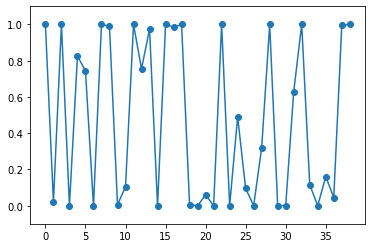

In [71]:
plt.plot(accuracy,'-o')
plt.ylim([-0.1,1.1])

In [61]:
len(sources)

9

In [62]:
spl=nx.shortest_path_length(nx.from_numpy_array(connectivity.adj_matrix),sources[5],drain_pool[0])

In [63]:
spl

16

In [64]:
((onAmp-sim[0].wireVoltage[:,drain_pool[0]])/spl)

AttributeError: 'NoneType' object has no attribute 'wireVoltage'